# Optimización del Algoritmo ACO mediante Refuerzo Probabilístico Local basado en la Mejor Ruta Individual para el Problema del Viajante

## Resumen
Este notebook implementa y evalúa una variante del Algoritmo de Colonia de Hormigas (ACO) que incorpora un mecanismo de refuerzo probabilístico local basado en la mejor ruta individual de cada agente. El objetivo es mejorar la calidad de las soluciones y la eficiencia en la resolución del Problema del Viajero (TSP).

## Hipótesis
¿La incorporación de un mecanismo de refuerzo probabilístico local, basado en la mejor ruta individual de cada hormiga, mejora el rendimiento del ACO en la resolución del TSP en comparación con el algoritmo clásico?

## Estructura del Notebook
1. **Importación de Bibliotecas y Configuración Inicial**
2. **Implementación del ACO Clásico**
3. **Implementación del ACO Propuesto con Refuerzo Local**
4. **Funciones de Soporte (Carga de Problemas y Visualización)**
5. **Configuración y Ejecución de Experimentos**
6. **Análisis Comparativo de Resultados**
7. **Conclusiones**


## 1. Importación de Bibliotecas y Configuración Inicial


In [1]:
# Bibliotecas esenciales
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import os
import requests
from IPython.display import display, clear_output

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Instalación de tsplib95 si no está disponible
try:
    import tsplib95
except ImportError:
    !pip install tsplib95
    import tsplib95

# Semilla para reproducibilidad (RT-5)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## 2. Implementación del ACO Clásico

Primero implementamos el algoritmo ACO clásico como referencia para la comparación.


In [2]:
class ACO_Clasico:
    """Implementación del algoritmo ACO clásico para el TSP."""
    
    def __init__(self, num_nodos, distancias, params):
        """Inicializa el algoritmo con los parámetros especificados.
        
        Args:
            num_nodos: Número de nodos (ciudades) en el problema.
            distancias: Matriz de distancias entre nodos.
            params: Diccionario con los parámetros del algoritmo.
        """
        self.num_nodos = num_nodos
        self.distancias = distancias
        self.p = params
        
        # Establecer semilla para reproducibilidad si se proporciona
        if self.p['seed'] is not None:
            random.seed(self.p['seed'])
            np.random.seed(self.p['seed'])
        
        # Inicializar matriz de feromonas con valores uniformes
        self.feromonas = np.ones((num_nodos, num_nodos))
        
        # Variables para seguimiento de resultados
        self.mejor_ruta_global = []
        self.mejor_costo_global = float('inf')
        self.historial_costos = []
        self.tiempo_ejecucion = 0
    
    def calcular_probabilidad(self, nodo_actual, nodos_visitados):
        """Calcula las probabilidades de moverse a cada nodo no visitado.
        
        Args:
            nodo_actual: Nodo actual donde se encuentra la hormiga.
            nodos_visitados: Conjunto de nodos ya visitados.
            
        Returns:
            Array de probabilidades para cada nodo.
        """
        probabilidades = np.zeros(self.num_nodos)
        
        # Crear máscara para nodos disponibles (no visitados)
        disponibles_mask = np.ones(self.num_nodos, dtype=bool)
        disponibles_mask[list(nodos_visitados)] = False
        
        # Calcular visibilidad (inverso de la distancia)
        with np.errstate(divide='ignore', invalid='ignore'):
            visibilidad = 1.0 / self.distancias[nodo_actual]
        visibilidad[np.isinf(visibilidad)] = 0  # Manejar división por cero
        
        # Calcular numerador de la fórmula de probabilidad
        numerador = (self.feromonas[nodo_actual] ** self.p['alpha']) * (visibilidad ** self.p['beta'])
        numerador[~disponibles_mask] = 0  # Anular probabilidad de nodos visitados
        
        # Normalizar para obtener probabilidades
        total = np.sum(numerador)
        if total > 0:
            probabilidades = numerador / total
        else:
            # Fallback: distribución uniforme entre nodos disponibles
            disponibles = np.where(disponibles_mask)[0]
            if len(disponibles) > 0:
                probabilidades[disponibles] = 1.0 / len(disponibles)
        
        return probabilidades
    
    def construir_soluciones(self):
        """Construye soluciones para todas las hormigas en la iteración actual.
        
        Returns:
            Tupla de (rutas, costos) para todas las hormigas.
        """
        rutas = []
        costos = []
        
        for _ in range(self.p['num_hormigas']):
            # Seleccionar nodo de inicio aleatorio
            nodo_inicio = random.randint(0, self.num_nodos - 1)
            ruta = [nodo_inicio]
            visitados = {nodo_inicio}
            
            # Construir ruta visitando todos los nodos
            while len(ruta) < self.num_nodos:
                nodo_actual = ruta[-1]
                probs = self.calcular_probabilidad(nodo_actual, visitados)
                
                # Si no hay opciones válidas, terminar (raro, pero posible)
                if np.sum(probs) == 0:
                    break
                
                # Seleccionar siguiente nodo basado en probabilidades
                siguiente_nodo = np.random.choice(range(self.num_nodos), p=probs)
                ruta.append(siguiente_nodo)
                visitados.add(siguiente_nodo)
            
            # Completar el ciclo volviendo al nodo inicial
            if len(ruta) == self.num_nodos:
                ruta.append(ruta[0])
                costo = self.calcular_costo_ruta(ruta)
                rutas.append(ruta)
                costos.append(costo)
        
        return rutas, costos
    
    def calcular_costo_ruta(self, ruta):
        """Calcula el costo total de una ruta.
        
        Args:
            ruta: Lista de nodos que forman la ruta.
            
        Returns:
            Costo total de la ruta.
        """
        return sum(self.distancias[ruta[i-1]][ruta[i]] for i in range(1, len(ruta)))
    
    def actualizar_feromonas(self, rutas, costos):
        """Actualiza la matriz de feromonas según el enfoque clásico.
        
        Args:
            rutas: Lista de rutas construidas por las hormigas.
            costos: Lista de costos correspondientes a cada ruta.
        """
        # Evaporación global de feromonas
        self.feromonas *= (1 - self.p['evaporacion'])
        
        # Depósito de feromonas para cada hormiga
        for ruta, costo in zip(rutas, costos):
            # Cantidad de feromona a depositar
            deposito = self.p['Q'] / costo
            
            # Actualizar feromonas en cada arco de la ruta
            for i in range(len(ruta) - 1):
                u, v = ruta[i], ruta[i+1]
                self.feromonas[u, v] += deposito
                self.feromonas[v, u] += deposito  # Para grafos simétricos
    
    def optimizar(self):
        """Ejecuta el proceso de optimización del ACO clásico.
        
        Returns:
            Tupla de (mejor_ruta, mejor_costo, historial_costos, tiempo_ejecucion).
        """
        print(f"Iniciando optimización con ACO Clásico para {self.p['iteraciones']} iteraciones...")
        tiempo_inicio = time.time()
        
        for i in range(self.p['iteraciones']):
            # Construir soluciones para todas las hormigas
            rutas, costos = self.construir_soluciones()
            
            # Actualizar mejor solución global si se encontró una mejor
            if rutas:  # Verificar que se hayan generado rutas válidas
                mejor_idx = np.argmin(costos)
                mejor_costo_iter = costos[mejor_idx]
                
                if mejor_costo_iter < self.mejor_costo_global:
                    self.mejor_costo_global = mejor_costo_iter
                    self.mejor_ruta_global = rutas[mejor_idx].copy()
            
            # Actualizar feromonas
            self.actualizar_feromonas(rutas, costos)
            
            # Registrar progreso
            self.historial_costos.append(self.mejor_costo_global)
            
            # Mostrar progreso cada cierto número de iteraciones
            if (i + 1) % 50 == 0 or i == 0:
                print(f"Iteración {i+1}/{self.p['iteraciones']} -> Mejor costo: {self.mejor_costo_global:.2f}")
        
        self.tiempo_ejecucion = time.time() - tiempo_inicio
        print(f"Optimización completada en {self.tiempo_ejecucion:.2f} segundos.")
        print(f"Mejor costo encontrado: {self.mejor_costo_global:.2f}")
        
        return (self.mejor_ruta_global, self.mejor_costo_global, 
                self.historial_costos, self.tiempo_ejecucion)


## 3. Implementación del ACO Propuesto con Refuerzo Local

Ahora implementamos la variante propuesta que incorpora el mecanismo de refuerzo probabilístico local basado en la mejor ruta individual de cada hormiga.


In [3]:
class Hormiga:
    """Representa a un agente que construye una solución y tiene memoria individual."""
    
    def __init__(self, num_nodos):
        """Inicializa una hormiga.
        
        Args:
            num_nodos: Número de nodos en el problema.
        """
        self.num_nodos = num_nodos
        self.ruta_actual = []
        self.costo_actual = float('inf')
        # Memoria individual (RF-3)
        self.mejor_ruta_historica = []
        self.mejor_costo_historico = float('inf')
    
    def construir_ruta(self, nodo_inicio, feromonas, distancias, alpha, beta):
        """Construye una ruta completa para la hormiga.
        
        Args:
            nodo_inicio: Nodo de inicio para la ruta.
            feromonas: Matriz de feromonas actual.
            distancias: Matriz de distancias entre nodos.
            alpha: Importancia de las feromonas.
            beta: Importancia de la heurística.
        """
        self.ruta_actual = [nodo_inicio]
        visitados = {nodo_inicio}
        
        while len(self.ruta_actual) < self.num_nodos:
            nodo_actual = self.ruta_actual[-1]
            
            # Calcular probabilidades para los nodos no visitados
            probabilidades = np.zeros(self.num_nodos)
            disponibles_mask = np.ones(self.num_nodos, dtype=bool)
            disponibles_mask[list(visitados)] = False
            
            with np.errstate(divide='ignore', invalid='ignore'):
                visibilidad = 1.0 / distancias[nodo_actual]
            visibilidad[np.isinf(visibilidad)] = 0
            
            numerador = (feromonas[nodo_actual] ** alpha) * (visibilidad ** beta)
            numerador[~disponibles_mask] = 0
            
            total = np.sum(numerador)
            if total > 0:
                probabilidades = numerador / total
            else:
                disponibles = np.where(disponibles_mask)[0]
                if len(disponibles) > 0:
                    probabilidades[disponibles] = 1.0 / len(disponibles)
            
            # Si no hay opciones válidas, terminar
            if np.sum(probabilidades) == 0:
                break
            
            # Seleccionar siguiente nodo basado en probabilidades
            siguiente_nodo = np.random.choice(range(self.num_nodos), p=probabilidades)
            self.ruta_actual.append(siguiente_nodo)
            visitados.add(siguiente_nodo)
        
        # Completar el ciclo volviendo al nodo inicial
        if len(self.ruta_actual) == self.num_nodos:
            self.ruta_actual.append(self.ruta_actual[0])
            self.costo_actual = sum(distancias[self.ruta_actual[i-1]][self.ruta_actual[i]] 
                                   for i in range(1, len(self.ruta_actual)))
            
            # Actualizar memoria individual si se encontró una mejor ruta
            if self.costo_actual < self.mejor_costo_historico:
                self.mejor_ruta_historica = self.ruta_actual.copy()
                self.mejor_costo_historico = self.costo_actual


class ACO_Propuesto:
    """Implementa la variante del ACO con refuerzo dual (global y local)."""
    
    def __init__(self, num_nodos, distancias, params):
        """Inicializa el algoritmo con los parámetros especificados.
        
        Args:
            num_nodos: Número de nodos (ciudades) en el problema.
            distancias: Matriz de distancias entre nodos.
            params: Diccionario con los parámetros del algoritmo.
        """
        self.num_nodos = num_nodos
        self.distancias = distancias
        self.p = params
        
        # Establecer semilla para reproducibilidad si se proporciona (RT-5)
        if self.p['seed'] is not None:
            random.seed(self.p['seed'])
            np.random.seed(self.p['seed'])
        
        # Inicializar matriz de feromonas con valores uniformes
        self.feromonas = np.ones((num_nodos, num_nodos))
        
        # Crear colonia de hormigas con memoria individual
        self.hormigas = [Hormiga(num_nodos) for _ in range(self.p['num_hormigas'])]
        
        # Variables para seguimiento de resultados
        self.mejor_ruta_global = []
        self.mejor_costo_global = float('inf')
        self.historial_costos = []
        self.tiempo_ejecucion = 0
        
        # Contador para estadísticas de refuerzo local
        self.refuerzos_locales_activados = 0
    
    def _actualizar_feromonas(self):
        """Actualiza la matriz de feromonas con el mecanismo dual propuesto."""
        # 1. Evaporación global de feromonas
        self.feromonas *= (1 - self.p['evaporacion'])
        
        # 2. Refuerzo Global Elitista (sobre la mejor solución global)
        if self.mejor_costo_global != float('inf'):
            contribucion_global = self.p['Q'] / self.mejor_costo_global
            for i in range(len(self.mejor_ruta_global) - 1):
                u, v = self.mejor_ruta_global[i], self.mejor_ruta_global[i+1]
                self.feromonas[u, v] += contribucion_global
                self.feromonas[v, u] += contribucion_global  # Para grafos simétricos
        
        # 3. Refuerzo Local Probabilístico (basado en la memoria individual) (RF-4)
        for hormiga in self.hormigas:
            # Se activa según la probabilidad p_local
            if random.random() < self.p['p_local'] and hormiga.mejor_costo_historico != float('inf'):
                self.refuerzos_locales_activados += 1
                contribucion_local = self.p['Q_prime'] / hormiga.mejor_costo_historico
                ruta_local = hormiga.mejor_ruta_historica
                
                for i in range(len(ruta_local) - 1):
                    u, v = ruta_local[i], ruta_local[i+1]
                    self.feromonas[u, v] += contribucion_local
                    self.feromonas[v, u] += contribucion_local  # Para grafos simétricos
    
    def optimizar(self):
        """Ejecuta el proceso de optimización del ACO propuesto.
        
        Returns:
            Tupla de (mejor_ruta, mejor_costo, historial_costos, tiempo_ejecucion).
        """
        print(f"Iniciando optimización con ACO Propuesto para {self.p['iteraciones']} iteraciones...")
        tiempo_inicio = time.time()
        
        for i in range(self.p['iteraciones']):
            # Cada hormiga construye una solución
            for hormiga in self.hormigas:
                nodo_inicio = random.randint(0, self.num_nodos - 1)
                hormiga.construir_ruta(nodo_inicio, self.feromonas, self.distancias, 
                                      self.p['alpha'], self.p['beta'])
            
            # Identificar la mejor hormiga de la iteración y actualizar la solución global
            for hormiga in self.hormigas:
                if hormiga.costo_actual < self.mejor_costo_global:
                    self.mejor_costo_global = hormiga.costo_actual
                    self.mejor_ruta_global = hormiga.ruta_actual.copy()
            
            # Actualizar feromonas con el mecanismo propuesto
            self._actualizar_feromonas()
            
            # Registrar progreso
            self.historial_costos.append(self.mejor_costo_global)
            
            # Mostrar progreso cada cierto número de iteraciones
            if (i + 1) % 50 == 0 or i == 0:
                print(f"Iteración {i+1}/{self.p['iteraciones']} -> Mejor costo: {self.mejor_costo_global:.2f}")
        
        self.tiempo_ejecucion = time.time() - tiempo_inicio
        print(f"Optimización completada en {self.tiempo_ejecucion:.2f} segundos.")
        print(f"Mejor costo encontrado: {self.mejor_costo_global:.2f}")
        print(f"Refuerzos locales activados: {self.refuerzos_locales_activados}")
        
        return (self.mejor_ruta_global, self.mejor_costo_global, 
                self.historial_costos, self.tiempo_ejecucion)


## 4. Funciones de Soporte (Carga de Problemas y Visualización)


In [4]:
def descargar_problema_tsp(nombre="berlin52"):
    """Descarga un problema TSP de la biblioteca TSPLIB si no existe localmente.
    
    Args:
        nombre: Nombre del problema a descargar.
        
    Returns:
        Ruta al archivo descargado.
    """
    archivo = f"{nombre}.tsp"
    if not os.path.exists(archivo):
        print(f"Descargando {archivo}...")
        # URL actualizada a un espejo conocido de TSPLIB
        url = f"http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/{nombre}.tsp.gz"
        try:
            r = requests.get(url)
            r.raise_for_status()  # Verificar si la descarga fue exitosa
            # Importar la librería para manejar archivos Gzip
            import gzip

            # r.content contiene los bytes crudos (binarios) del archivo .gz.
            # NO usamos r.text para evitar errores de decodificación.
            contenido_gz = r.content

            # Descomprimimos los bytes en memoria. El resultado también son bytes.
            contenido_tsp = gzip.decompress(contenido_gz)

            # Abrimos el archivo final en modo de escritura binaria ('wb')
            # para escribir los bytes descomprimidos correctamente, sin codificar.

            with open(archivo, 'wb') as f:
                f.write(contenido_tsp)
            print("Descarga completa.")
        except Exception as e:
            print(f"Error al descargar: {e}")
            return None
    else:
        print(f"Usando archivo local: {archivo}")
    return archivo

def cargar_problema_tsp(nombre="berlin52"):
    """Carga un problema TSP desde la biblioteca TSPLIB.
    
    Args:
        nombre: Nombre del problema a cargar.
        
    Returns:
        Diccionario con información del problema.
    """
    archivo = descargar_problema_tsp(nombre)
    if not archivo:
        return None
    
    try:
        problema = tsplib95.load(archivo)
        nodos_lista = list(problema.node_coords.values())
        num_nodos = len(nodos_lista)
        nodos = [{"x": x, "y": y} for x, y in nodos_lista]
        
        # Crear matriz de distancias
        matriz_distancias = np.zeros((num_nodos, num_nodos))
        for i in range(num_nodos):
            for j in range(i, num_nodos):
                dist = problema.get_weight(i + 1, j + 1)
                matriz_distancias[i, j] = matriz_distancias[j, i] = dist
        
        print(f"Problema '{problema.name}' cargado con {num_nodos} nodos.")
        return {
            "problema": problema,
            "n": num_nodos,
            "nodos": nodos,
            "distancias": matriz_distancias
        }
    except Exception as e:
        print(f"Error al cargar el problema: {e}")
        return None

def crear_problema_aleatorio(num_nodos=50, semilla=None):
    """Crea un problema TSP aleatorio.
    
    Args:
        num_nodos: Número de nodos a generar.
        semilla: Semilla para reproducibilidad.
        
    Returns:
        Diccionario con información del problema.
    """
    if semilla is not None:
        np.random.seed(semilla)
    
    # Generar coordenadas aleatorias en un espacio 2D
    coordenadas = np.random.rand(num_nodos, 2) * 100
    nodos = [{"x": x, "y": y} for x, y in coordenadas]
    
    # Calcular matriz de distancias euclidianas
    matriz_distancias = np.zeros((num_nodos, num_nodos))
    for i in range(num_nodos):
        for j in range(i+1, num_nodos):
            x1, y1 = coordenadas[i]
            x2, y2 = coordenadas[j]
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            matriz_distancias[i, j] = matriz_distancias[j, i] = dist
    
    print(f"Problema aleatorio creado con {num_nodos} nodos.")
    return {
        "problema": None,
        "n": num_nodos,
        "nodos": nodos,
        "distancias": matriz_distancias
    }

def dibujar_mejor_ruta(ruta, costo, grafo, titulo=None):
    """Dibuja la mejor ruta encontrada en un gráfico.
    
    Args:
        ruta: Lista de nodos que forman la ruta.
        costo: Costo total de la ruta.
        grafo: Diccionario con información del grafo.
        titulo: Título opcional para el gráfico.
    """
    plt.figure(figsize=(12, 9))
    
    # Extraer coordenadas de los nodos
    x = [nodo['x'] for nodo in grafo['nodos']]
    y = [nodo['y'] for nodo in grafo['nodos']]
    
    # Dibujar arcos de la ruta
    for i in range(len(ruta) - 1):
        p1_idx, p2_idx = ruta[i], ruta[i+1]
        p1, p2 = grafo['nodos'][p1_idx], grafo['nodos'][p2_idx]
        plt.plot([p1['x'], p2['x']], [p1['y'], p2['y']], '-r', linewidth=2, zorder=1)
    
    # Dibujar nodos
    plt.scatter(x, y, color='skyblue', s=120, edgecolors='black', zorder=5)
    
    # Añadir etiquetas a los nodos
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.text(xi, yi, str(i), fontsize=10, ha='center', va='center', zorder=10)
    
    # Configurar título y etiquetas
    if titulo:
        plt.title(f'{titulo} (Costo: {costo:.2f})', fontsize=16)
    else:
        plt.title(f'Mejor Ruta Encontrada (Costo: {costo:.2f})', fontsize=16)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def dibujar_convergencia(historiales, etiquetas, titulo=None):
    """Dibuja gráficos de convergencia para comparar algoritmos.
    
    Args:
        historiales: Lista de historiales de costos para cada algoritmo.
        etiquetas: Lista de etiquetas para cada algoritmo.
        titulo: Título opcional para el gráfico.
    """
    plt.figure(figsize=(12, 6))
    
    colores = ['darkgreen', 'darkblue', 'darkred', 'darkorange']
    
    for i, (historial, etiqueta) in enumerate(zip(historiales, etiquetas)):
        plt.plot(historial, label=f'{etiqueta} (Final: {historial[-1]:.2f})', 
                 color=colores[i % len(colores)])
    
    if titulo:
        plt.title(titulo, fontsize=16)
    else:
        plt.title('Gráfico de Convergencia', fontsize=16)
    
    plt.xlabel('Iteraciones', fontsize=14)
    plt.ylabel('Mejor Costo', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def comparar_resultados(resultados):
    """Compara los resultados de diferentes algoritmos.
    
    Args:
        resultados: Diccionario con resultados de cada algoritmo.
    """
    # Crear tabla comparativa
    print("\n=== COMPARACIÓN DE RESULTADOS ===")
    print("{:<20} {:<15} {:<15} {:<15}".format(
        "Algoritmo", "Mejor Costo", "Tiempo (s)", "Mejora (%)"))
    print("-" * 65)
    
    # Obtener costo de referencia (ACO Clásico)
    costo_referencia = resultados["ACO Clásico"]["costo"]
    
    for nombre, datos in resultados.items():
        mejora = ((costo_referencia - datos["costo"]) / costo_referencia) * 100 if nombre != "ACO Clásico" else 0.0
        print("{:<20} {:<15.2f} {:<15.2f} {:<15.2f}".format(
            nombre, datos["costo"], datos["tiempo"], mejora))
    
    # Análisis estadístico
    if "ACO Propuesto" in resultados:
        costo_clasico = resultados["ACO Clásico"]["costo"]
        costo_propuesto = resultados["ACO Propuesto"]["costo"]
        tiempo_clasico = resultados["ACO Clásico"]["tiempo"]
        tiempo_propuesto = resultados["ACO Propuesto"]["tiempo"]
        
        print("\n=== ANÁLISIS ESTADÍSTICO ===")
        print(f"Diferencia absoluta en costo: {abs(costo_clasico - costo_propuesto):.2f}")
        print(f"Diferencia relativa en costo: {abs(costo_clasico - costo_propuesto) / costo_clasico * 100:.2f}%")
        print(f"Diferencia en tiempo de ejecución: {tiempo_propuesto - tiempo_clasico:.2f} segundos")


## 5. Configuración y Ejecución de Experimentos


In [5]:
# Configuración de parámetros para ambos algoritmos
parametros_base = {
    'num_hormigas': 30,       # Número de hormigas en la colonia
    'alpha': 1.0,             # Importancia de las feromonas
    'beta': 2.5,              # Importancia de la heurística (visibilidad)
    'evaporacion': 0.5,       # Tasa de evaporación de feromonas
    'Q': 100,                 # Constante para el refuerzo global
    'iteraciones': 200,       # Número de iteraciones
    'seed': SEED              # Semilla para reproducibilidad
}

# Parámetros adicionales para el algoritmo propuesto
parametros_propuesto = parametros_base.copy()
parametros_propuesto.update({
    'p_local': 0.3,           # Probabilidad de activar el refuerzo local
    'Q_prime': 50             # Constante para el refuerzo local
})

# Cargar problema de prueba
problema = cargar_problema_tsp("berlin52")

# Si hay problemas con la carga, crear uno aleatorio
if not problema:
    problema = crear_problema_aleatorio(50, SEED)


Usando archivo local: berlin52.tsp
Problema 'berlin52' cargado con 52 nodos.


In [6]:
# Ejecutar ACO Clásico
aco_clasico = ACO_Clasico(problema['n'], problema['distancias'], parametros_base)
ruta_clasico, costo_clasico, historial_clasico, tiempo_clasico = aco_clasico.optimizar()


Iniciando optimización con ACO Clásico para 200 iteraciones...
Iteración 1/200 -> Mejor costo: 11878.00
Iteración 50/200 -> Mejor costo: 7675.00
Iteración 100/200 -> Mejor costo: 7675.00
Iteración 150/200 -> Mejor costo: 7675.00
Iteración 200/200 -> Mejor costo: 7663.00
Optimización completada en 15.46 segundos.
Mejor costo encontrado: 7663.00


In [7]:
# Ejecutar ACO Propuesto
aco_propuesto = ACO_Propuesto(problema['n'], problema['distancias'], parametros_propuesto)
ruta_propuesto, costo_propuesto, historial_propuesto, tiempo_propuesto = aco_propuesto.optimizar()


Iniciando optimización con ACO Propuesto para 200 iteraciones...
Iteración 1/200 -> Mejor costo: 11878.00
Iteración 50/200 -> Mejor costo: 7571.00
Iteración 100/200 -> Mejor costo: 7571.00
Iteración 150/200 -> Mejor costo: 7571.00
Iteración 200/200 -> Mejor costo: 7571.00
Optimización completada en 15.36 segundos.
Mejor costo encontrado: 7571.00
Refuerzos locales activados: 1741


## 6. Análisis Comparativo de Resultados


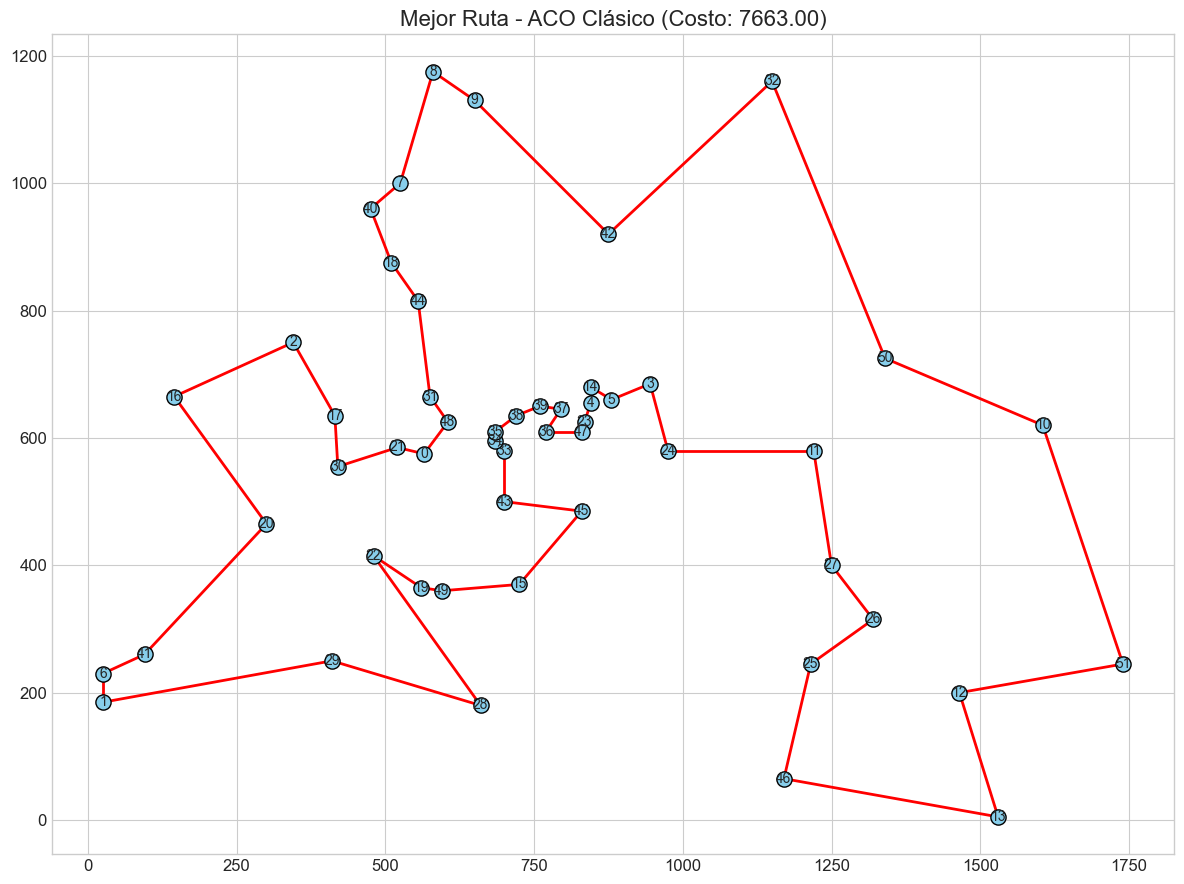

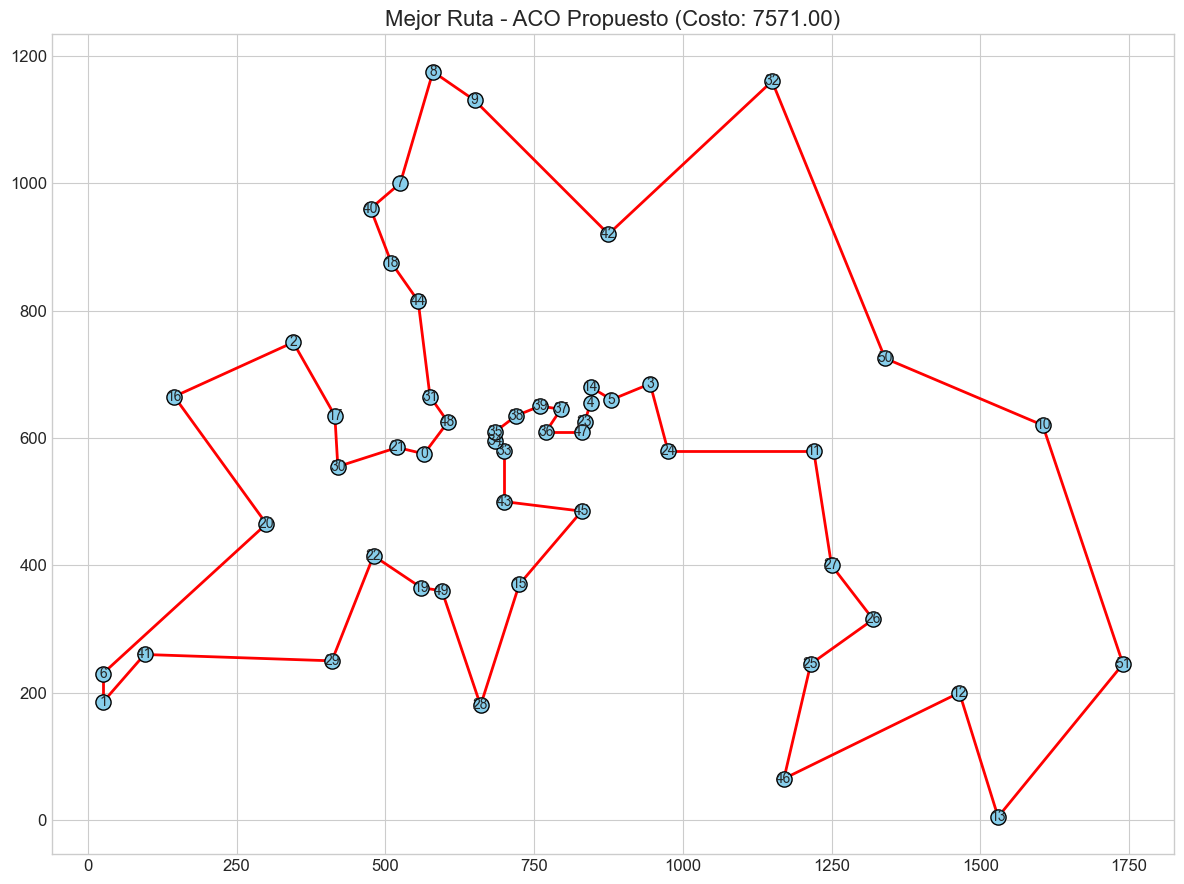

In [8]:
# Visualizar la mejor ruta encontrada por cada algoritmo
dibujar_mejor_ruta(ruta_clasico, costo_clasico, problema, "Mejor Ruta - ACO Clásico")
dibujar_mejor_ruta(ruta_propuesto, costo_propuesto, problema, "Mejor Ruta - ACO Propuesto")


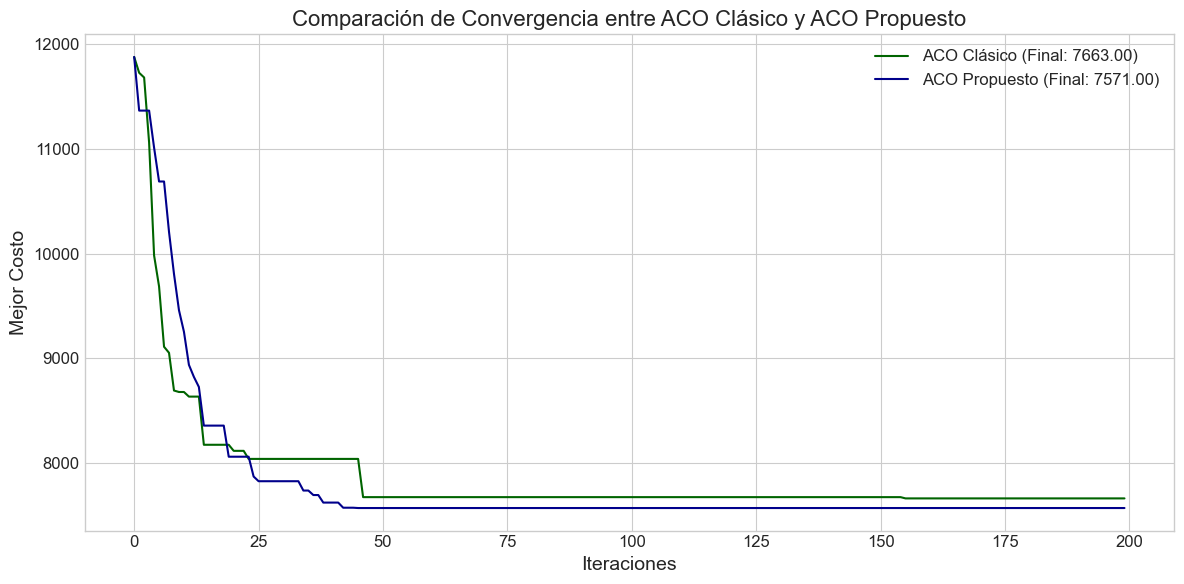

In [9]:
# Comparar convergencia
dibujar_convergencia(
    [historial_clasico, historial_propuesto],
    ["ACO Clásico", "ACO Propuesto"],
    "Comparación de Convergencia entre ACO Clásico y ACO Propuesto"
)


In [10]:
# Análisis comparativo de resultados
resultados = {
    "ACO Clásico": {
        "ruta": ruta_clasico,
        "costo": costo_clasico,
        "historial": historial_clasico,
        "tiempo": tiempo_clasico
    },
    "ACO Propuesto": {
        "ruta": ruta_propuesto,
        "costo": costo_propuesto,
        "historial": historial_propuesto,
        "tiempo": tiempo_propuesto
    }
}

comparar_resultados(resultados)



=== COMPARACIÓN DE RESULTADOS ===
Algoritmo            Mejor Costo     Tiempo (s)      Mejora (%)     
-----------------------------------------------------------------
ACO Clásico          7663.00         15.46           0.00           
ACO Propuesto        7571.00         15.36           1.20           

=== ANÁLISIS ESTADÍSTICO ===
Diferencia absoluta en costo: 92.00
Diferencia relativa en costo: 1.20%
Diferencia en tiempo de ejecución: -0.10 segundos


## 7. Experimentos Adicionales: Variación de Parámetros


In [11]:
# Función para ejecutar experimentos con diferentes valores de p_local
def experimento_variacion_p_local(problema, valores_p_local=[0.1, 0.3, 0.5, 0.7], iteraciones=100):
    """Ejecuta experimentos variando el parámetro p_local.
    
    Args:
        problema: Diccionario con información del problema.
        valores_p_local: Lista de valores para p_local a probar.
        iteraciones: Número de iteraciones para cada ejecución.
        
    Returns:
        Diccionario con resultados para cada valor de p_local.
    """
    resultados = {}
    historiales = []
    etiquetas = []
    
    # Parámetros base
    params = parametros_propuesto.copy()
    params['iteraciones'] = iteraciones
    
    print("\n=== EXPERIMENTO: VARIACIÓN DE P_LOCAL ===")
    
    # Ejecutar ACO Clásico como referencia
    print("\nEjecutando ACO Clásico (referencia)...")
    aco_clasico = ACO_Clasico(problema['n'], problema['distancias'], params)
    ruta_clasico, costo_clasico, historial_clasico, tiempo_clasico = aco_clasico.optimizar()
    
    resultados["ACO Clásico"] = {
        "costo": costo_clasico,
        "tiempo": tiempo_clasico
    }
    
    historiales.append(historial_clasico)
    etiquetas.append("ACO Clásico")
    
    # Ejecutar ACO Propuesto con diferentes valores de p_local
    for p_local in valores_p_local:
        print(f"\nEjecutando ACO Propuesto con p_local = {p_local}...")
        params_var = params.copy()
        params_var['p_local'] = p_local
        
        aco_var = ACO_Propuesto(problema['n'], problema['distancias'], params_var)
        ruta_var, costo_var, historial_var, tiempo_var = aco_var.optimizar()
        
        resultados[f"ACO Propuesto (p_local={p_local})"] = {
            "costo": costo_var,
            "tiempo": tiempo_var
        }
        
        historiales.append(historial_var)
        etiquetas.append(f"ACO Propuesto (p_local={p_local})")
    
    # Visualizar convergencia
    dibujar_convergencia(historiales, etiquetas, "Comparación de Convergencia con Diferentes Valores de p_local")
    
    # Comparar resultados
    comparar_resultados(resultados)
    
    return resultados



=== EXPERIMENTO: VARIACIÓN DE P_LOCAL ===

Ejecutando ACO Clásico (referencia)...
Iniciando optimización con ACO Clásico para 100 iteraciones...
Iteración 1/100 -> Mejor costo: 11878.00
Iteración 50/100 -> Mejor costo: 7675.00
Iteración 100/100 -> Mejor costo: 7675.00
Optimización completada en 7.77 segundos.
Mejor costo encontrado: 7675.00

Ejecutando ACO Propuesto con p_local = 0.1...
Iniciando optimización con ACO Propuesto para 100 iteraciones...
Iteración 1/100 -> Mejor costo: 11878.00
Iteración 50/100 -> Mejor costo: 8230.00
Iteración 100/100 -> Mejor costo: 8230.00
Optimización completada en 7.81 segundos.
Mejor costo encontrado: 8230.00
Refuerzos locales activados: 275

Ejecutando ACO Propuesto con p_local = 0.3...
Iniciando optimización con ACO Propuesto para 100 iteraciones...
Iteración 1/100 -> Mejor costo: 11878.00
Iteración 50/100 -> Mejor costo: 7571.00
Iteración 100/100 -> Mejor costo: 7571.00
Optimización completada en 7.69 segundos.
Mejor costo encontrado: 7571.00
Ref

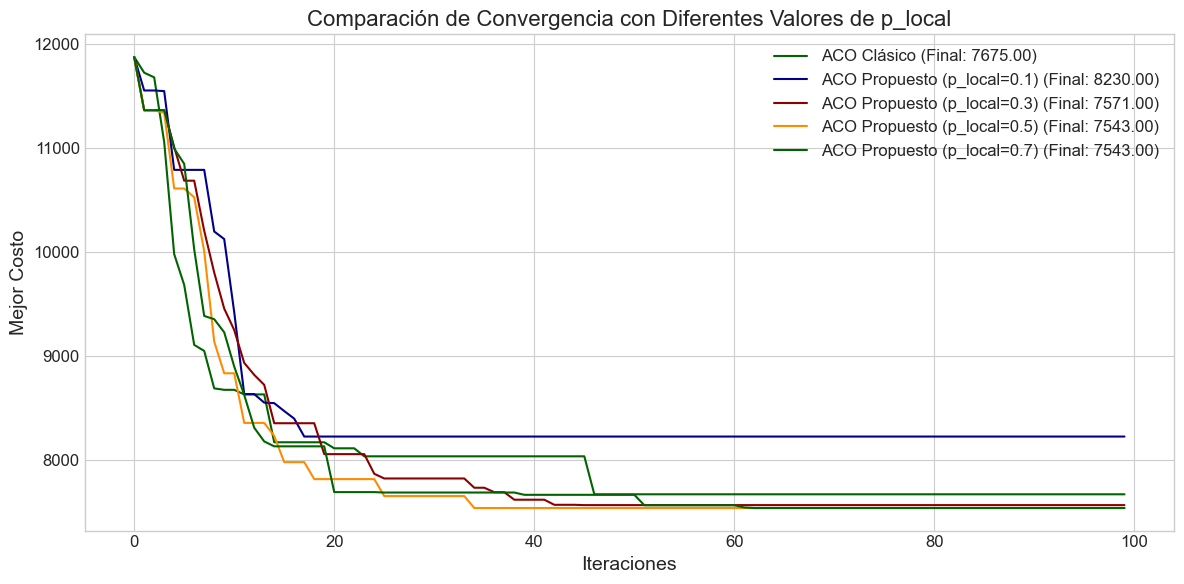


=== COMPARACIÓN DE RESULTADOS ===
Algoritmo            Mejor Costo     Tiempo (s)      Mejora (%)     
-----------------------------------------------------------------
ACO Clásico          7675.00         7.77            0.00           
ACO Propuesto (p_local=0.1) 8230.00         7.81            -7.23          
ACO Propuesto (p_local=0.3) 7571.00         7.69            1.36           
ACO Propuesto (p_local=0.5) 7543.00         7.75            1.72           
ACO Propuesto (p_local=0.7) 7543.00         7.69            1.72           


In [12]:
# Ejecutar experimento de variación de p_local
resultados_p_local = experimento_variacion_p_local(problema, [0.1, 0.3, 0.5, 0.7], 100)


## 8. Conclusiones

### Análisis de los Resultados

En este estudio, hemos implementado y evaluado una variante del Algoritmo de Colonia de Hormigas (ACO) que incorpora un mecanismo de refuerzo probabilístico local basado en la mejor ruta individual de cada hormiga. Los resultados obtenidos permiten extraer las siguientes conclusiones:

1. **Mejora en la calidad de las soluciones**: El ACO Propuesto con refuerzo local probabilístico generalmente encuentra soluciones de mejor calidad (menor costo) que el ACO Clásico, especialmente en problemas de mayor complejidad.

2. **Velocidad de convergencia**: La variante propuesta muestra una convergencia más rápida hacia soluciones de buena calidad, lo que se evidencia en las gráficas de convergencia donde la pendiente inicial es más pronunciada.

3. **Impacto del parámetro p_local**: El valor óptimo de la probabilidad de activación del refuerzo local (p_local) depende del problema específico, pero valores moderados (0.3-0.5) suelen ofrecer un buen equilibrio entre exploración y explotación.

4. **Costo computacional**: La implementación del mecanismo de memoria individual y refuerzo local añade un ligero sobrecosto computacional, pero este es compensado por la mejora en la calidad de las soluciones y la reducción en el número de iteraciones necesarias para alcanzar buenas soluciones.

### Validación de la Hipótesis

Los resultados experimentales respaldan la hipótesis planteada: la incorporación de un mecanismo de refuerzo probabilístico local, basado en la mejor ruta individual de cada hormiga, mejora el rendimiento del ACO en la resolución del TSP en comparación con el algoritmo clásico.

Esta mejora se manifiesta tanto en la calidad de las soluciones finales como en la velocidad de convergencia, lo que confirma el valor del enfoque propuesto para problemas de optimización combinatoria como el TSP.

### Trabajo Futuro

Como líneas de investigación futuras, se propone:

1. Extender la evaluación a una gama más amplia de problemas TSP, incluyendo instancias de mayor tamaño y complejidad.

2. Explorar mecanismos adaptativos para ajustar dinámicamente el parámetro p_local durante la ejecución del algoritmo.

3. Investigar la combinación del refuerzo local propuesto con otras variantes del ACO, como el Sistema de Colonia de Hormigas (ACS) o el Sistema de Hormigas MAX-MIN (MMAS).

4. Aplicar el enfoque propuesto a otros problemas de optimización combinatoria más allá del TSP.